In [ ]:
# importing required libraries 
import cv2 
import numpy as np 
import json 
import shutil
import os
import re
import zipfile
import time 
import random 
import matplotlib.pyplot as plt 

In [ ]:
# mounting google drive 
from google.colab import drive 
drive.mount('/content/drive/') 

Mounted at /content/drive/


In [ ]:
# [BEFORE RUNNING THIS CELL]:
# create a shortcut to the dataset folder - AI for Wildlife 1 -> 01.SPOTS Modelling Group -> Datasets -> Labelled_images  
# and copy the shortcut to your google drive to access the dataset from within colab 

# define dataset path (this will be different for your system based on google drive folder organization)
dataset_path = '/content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images'
!ls '/content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images' # to confirm if the shortcut path is set correctly

'dataset (4)'						        video53_5.zip
 dataset.zip						        video53_6.zip
'task_24 prep-2021_06_01_20_16_37-coco 1.0.zip'		        video53_7.zip
'task_26 prep-2021_06_07_03_59_26-coco 1.0 (1).zip'	        video53_8.zip
'task_black is hot 1-2021_06_17_14_43_48-coco 1.0.zip'	        video53_9.zip
'task_black_is_hot_slice_02-2021_06_17_18_56_04-coco 1.0.zip'  'Video 76'
 task_black_is_hot_slice_02_backup_2021_06_17_18_56_04.zip      video78_1.zip
 test_dataset.zip					        video82_1.zip
 video03_1.zip						        video82_2.zip
 video03_2.zip						        video82_3.zip
 video03_3.zip						        videobh_1.zip
 video07_1.zip						        videobh_2.zip
 video07_2.zip						        videobh_3.zip
 video53_1.zip						        videobh_41.zip
 video53_2.zip						        videobh_42.zip
 video53_3.zip						        videobh_43.zip
 video53_4.zip						        videobh_44.zip


In [ ]:
# creating a list of all .zip files 

# all files and folders in dataset_path 
all_files_folders = os.listdir(dataset_path)
#print(all_files_folders, type(all_files_folders))

# all zipped video files
zip_filenames = [f for f in all_files_folders if re.match(r'video',f)]
#print(zip_filenames)

# creating folder for saving unzipped files/folders
videos_folderpath = '/content/annotated_videos/'
if not os.path.exists(videos_folderpath) :
  os.mkdir(videos_folderpath)
  print("Created folder {}".format(videos_folderpath))
else :
  print("Folder {} already exists".format(videos_folderpath))


Created folder /content/annotated_videos/


In [ ]:
# unzipping the zip_filenames into videos_folderpath
start = time.time()
for zip_filename in zip_filenames :
  src_path = os.path.join(dataset_path, zip_filename)
  dst_path = os.path.join(videos_folderpath, zip_filename.split('.')[0])
  with zipfile.ZipFile(src_path, 'r') as zip_ref :
    print("Extracting file: {}".format(src_path))
    zip_ref.extractall(dst_path)
end = time.time()
time_taken = end-start 
print("Took {} seconds to unzip (also includes time for copying files from shared drive to colab for unzipping)".format(time_taken))

Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video82_2.zip
Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video03_3.zip
Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video03_2.zip
Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video03_1.zip
Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video53_9.zip
Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video78_1.zip
Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video07_1.zip
Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video07_2.zip
Extracting file: /content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/Labelled_images/video53_1.zip
Extracting

In [ ]:
# as per dataset generation code from last challenge: 
# final images were set to resolution width = 640, height = 470 (manually selected this resolution)
# any source images which resolution lower than final resolution were not included in the final dataset 
# therefore, based on knowledge from last challenge, 
# images from folders video03_1, video03_2, video03_3, video07_1, video07_2 are not included since their resolution is lower than final desired resolution 

subfolders_to_exclude = [ 'video03_1', 'video03_2', 'video03_3', 'video07_1', 'video07_2'  ]
print("Total number of folders in videos_folderpath before excluding low resolution videos: {}".format(len(os.listdir(videos_folderpath))))
videos_subfolders = [ name for name in os.listdir(videos_folderpath) if name not in subfolders_to_exclude ]
print("Total number of folders after excluding low resolution videos: {}".format(len(videos_subfolders)))
print('included subfolders:' , videos_subfolders)

Total number of folders in videos_folderpath before excluding low resolution videos: 25
Total number of folders after excluding low resolution videos: 20
included subfolders: ['videobh_44', 'videobh_42', 'videobh_41', 'video53_9', 'videobh_3', 'video53_2', 'video82_3', 'video53_3', 'video53_4', 'video53_8', 'video53_1', 'videobh_2', 'video53_7', 'videobh_43', 'video53_5', 'video82_2', 'video78_1', 'video53_6', 'video82_1', 'videobh_1']


In [ ]:
# defining helper function to find list of all images with and without poachers from the annotations file 
def get_annots_info(annots_filepath) :
  
  # opening annotations file for reading
  with open(annots_filepath, 'r') as fh :
    content = json.load(fh)
  
  # creating a set of all image_ids for which an annotation/bounding box is present 
  image_ids_with_annots = set()
  for annot in content['annotations'] :
    assert len(annot['bbox']) == 4 
    image_ids_with_annots.add(annot['image_id']) # annot['image_id'] is of type int 
    
  # creating list of all imagenames with poachers and imagenames without poachers
  images_with_poachers, images_without_poachers = [] , []
  for annot in content['images'] :
    image_id = annot['id'] # annot['id'] is of type int
    if image_id in image_ids_with_annots :
      images_with_poachers.append(annot['file_name'])
    else :
      images_without_poachers.append(annot['file_name'])
  
  return images_with_poachers, images_without_poachers


In [ ]:
# finding all images with and without poachers 
dict_images_with_poachers    = dict()
dict_images_without_poachers = dict()
for subfolder in videos_subfolders :
  annots_filepath = os.path.join(videos_folderpath, subfolder, 'annotations', 'instances_default.json')
  images_with_poachers, images_without_poachers = get_annots_info(annots_filepath)
  dict_images_with_poachers[subfolder]    = images_with_poachers 
  dict_images_without_poachers[subfolder] = images_without_poachers 

In [ ]:
# not a requirement but checking if all videos have atleast 1 image with poacher and 1 image without poacher 
assert sorted(dict_images_with_poachers.keys()) == sorted(dict_images_without_poachers.keys())

print('folder name - ' , 'count images with poachers - ', 'count images without poachers')
total_count_images_with_poachers = 0 
total_count_images_without_poachers = 0
for folder_name in dict_images_with_poachers.keys() :
  count_images_with_poachers   =  len(dict_images_with_poachers[folder_name]) 
  count_images_without_poachers = len(dict_images_without_poachers[folder_name]) 
  total_count_images_with_poachers += count_images_with_poachers
  total_count_images_without_poachers += count_images_without_poachers
  print("{}: {} {}".format(folder_name, count_images_with_poachers, count_images_without_poachers ))
print("Total counts: {} {}".format(total_count_images_with_poachers, total_count_images_without_poachers))

folder name -  count images with poachers -  count images without poachers
videobh_44: 70 28
videobh_42: 343 21
videobh_41: 383 42
video53_9: 1016 328
videobh_3: 1787 3613
video53_2: 2028 517
video82_3: 926 0
video53_3: 1003 285
video53_4: 524 46
video53_8: 331 0
video53_1: 2153 1439
videobh_2: 963 4437
video53_7: 281 170
videobh_43: 43 52
video53_5: 451 179
video82_2: 581 210
video78_1: 738 1055
video53_6: 373 227
video82_1: 402 730
videobh_1: 4287 1113
Total counts: 18683 14492


###IMPORTANT: Note that count of images with poachers printed above may be higher than the corresponding values in the final annotations dataset for images with poachers (from challenge 1) . Reason is likely the added filtering in original challenge 1 code for removing images where annotation bounding boxes are partially or fully falling within the cropped regions (original images captured from thermal camera are center cropped to remove black borders )

In [ ]:
# creating lists for saving source image filepaths (for images without poachers) for train, val and test images 
# folders video82_1, video82_2, video82_3 are used exclusively for test images (similar to challenge 1 dataset creation code)

# finding all train and validation filepaths 
src_train_val_filepaths = []
for folder_name, image_names in dict_images_without_poachers.items() :
  if re.match(r'video82' , folder_name) :
    print('Skipping folder {} since used in test set'.format(folder_name))
    continue 
  src_paths = [ os.path.join(videos_folderpath, folder_name, 'images' , image_name) for image_name in image_names ]
  src_train_val_filepaths.extend(src_paths)
src_train_val_filepaths = sorted(src_train_val_filepaths) # optionally sorting filepaths 
print("Total number of train+validation images: {}".format(len(src_train_val_filepaths)))

# randomnly splitting train and validation filepaths 
random.seed(0)  # setting seed to that the same split is obtained each time 
shuffled_filepaths = random.sample(src_train_val_filepaths, k=len(src_train_val_filepaths))
#print(shuffled_filepaths[:5]) # for verifying reproducibility of results 
num_train_images    = int(0.8*len(src_train_val_filepaths))  # 0.8 was also the splitting ratio used in original code from challenge 1 
src_train_filepaths = shuffled_filepaths[:num_train_images]
src_val_filepaths   = shuffled_filepaths[num_train_images:]
print("Total number of train images: {}".format(len(src_train_filepaths)))
print("Total number of validation images: {}".format(len(src_val_filepaths)))

# finding all test filepaths 
src_test_filepaths = []
for folder_name, image_names in dict_images_without_poachers.items() :
  if re.match(r'video82' , folder_name) : 
    src_paths = [ os.path.join(videos_folderpath, folder_name, 'images' , image_name) for image_name in image_names ]
    src_test_filepaths.extend(src_paths)
src_test_filepaths = sorted(src_test_filepaths) # optionally sorting filepaths 
print("Total number of test images: {}".format(len(src_test_filepaths)))


Skipping folder video82_3 since used in test set
Skipping folder video82_2 since used in test set
Skipping folder video82_1 since used in test set
Total number of train+validation images: 13552
Total number of train images: 10841
Total number of validation images: 2711
Total number of test images: 940


In [ ]:
# OPTIONAL - !rm -r '/content/images_without_poachers'

# creating destination folders for train, val and test images  
dst_base_folder  = '/content/images_without_poachers'
dst_train_folder = os.path.join(dst_base_folder, 'train')
dst_val_folder   = os.path.join(dst_base_folder, 'val')
dst_test_folder  = os.path.join(dst_base_folder, 'test')
for folderpath in [dst_base_folder, dst_train_folder, dst_val_folder, dst_test_folder] :
  if not os.path.exists(folderpath) :
    os.mkdir(folderpath)
    print("Created folder {}".format(folderpath))
  else :
    print("Folder {} already exists".format(folderpath))

Created folder /content/images_without_poachers
Created folder /content/images_without_poachers/train
Created folder /content/images_without_poachers/val
Created folder /content/images_without_poachers/test


In [ ]:
# setting output/destination image width and height similar to challenge1
dst_w = 640
dst_h = 470

# opening, cropping and saving train set images without poachers 
for src_filepath in src_train_filepaths :
  src_filename   = src_filepath.split(os.path.sep)[-1]
  src_foldername = src_filepath.split(os.path.sep)[-3]
  dst_filename   = src_foldername + '_' + src_filename
  dst_filepath   = os.path.join(dst_train_folder, dst_filename)
  image = cv2.imread( src_filepath , cv2.IMREAD_GRAYSCALE)
  image_h, image_w = image.shape 
  offset_h = int((image_h - dst_h)//2)
  offset_w = int((image_w - dst_w)//2)
  image = image[offset_h:offset_h+dst_h, offset_w:offset_w+dst_w ]             # center cropping the image to match required output width and height 
  cv2.imwrite(dst_filepath, image)


In [ ]:
# opening, cropping and saving validation set images without poachers 
for src_filepath in src_val_filepaths :
  src_filename   = src_filepath.split(os.path.sep)[-1]
  src_foldername = src_filepath.split(os.path.sep)[-3]
  dst_filename   = src_foldername + '_' + src_filename
  dst_filepath   = os.path.join(dst_val_folder, dst_filename)
  image = cv2.imread( src_filepath , cv2.IMREAD_GRAYSCALE)
  image_h, image_w = image.shape 
  offset_h = int((image_h - dst_h)//2)
  offset_w = int((image_w - dst_w)//2)
  image = image[offset_h:offset_h+dst_h, offset_w:offset_w+dst_w ]             # center cropping the image to match required output width and height 
  cv2.imwrite(dst_filepath, image)


In [ ]:
# opening, cropping and saving train set images without poachers 
for src_filepath in src_test_filepaths :
  src_filename   = src_filepath.split(os.path.sep)[-1]
  src_foldername = src_filepath.split(os.path.sep)[-3]
  dst_filename   = src_foldername + '_' + src_filename
  dst_filepath   = os.path.join(dst_test_folder, dst_filename)
  image = cv2.imread( src_filepath , cv2.IMREAD_GRAYSCALE)
  image_h, image_w = image.shape 
  offset_h = int((image_h - dst_h)//2)
  offset_w = int((image_w - dst_w)//2)
  image = image[offset_h:offset_h+dst_h, offset_w:offset_w+dst_w ]             # center cropping the image to match required output width and height 
  cv2.imwrite(dst_filepath, image)


In [ ]:
# verifying number of images in destination train, val and test folders 
print("destination train folder {} image count: {}".format(dst_train_folder, len(os.listdir(dst_train_folder))))
print("destination val folder {} image count: {}".format(dst_val_folder, len(os.listdir(dst_val_folder))))
print("destination test folder {} image count: {}".format(dst_test_folder, len(os.listdir(dst_test_folder))))

destination train folder /content/images_without_poachers/train image count: 10841
destination val folder /content/images_without_poachers/val image count: 2711
destination test folder /content/images_without_poachers/test image count: 940


In [ ]:
# visualizing sample images from train set 
dst_train_filenames = os.listdir(dst_train_folder)
dst_train_filepaths = [os.path.join(dst_train_folder, name) for name in dst_train_filenames ]
num_images_to_plot  = 16 
fig, axes = plt.subplots(4,4 , figsize=(24,10))
axes = axes.ravel()
for i in range(num_images_to_plot) :
  ax = axes[i]
  image_path = random.choice(dst_train_filepaths)
  image_name = image_path.split(os.path.sep)[-1]
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  ax.imshow(image, cmap='gray')
  ax.set_title(image_name)
  ax.axis('off')
fig.suptitle("Example images from train set (without poachers)", fontsize=16)
plt.show()


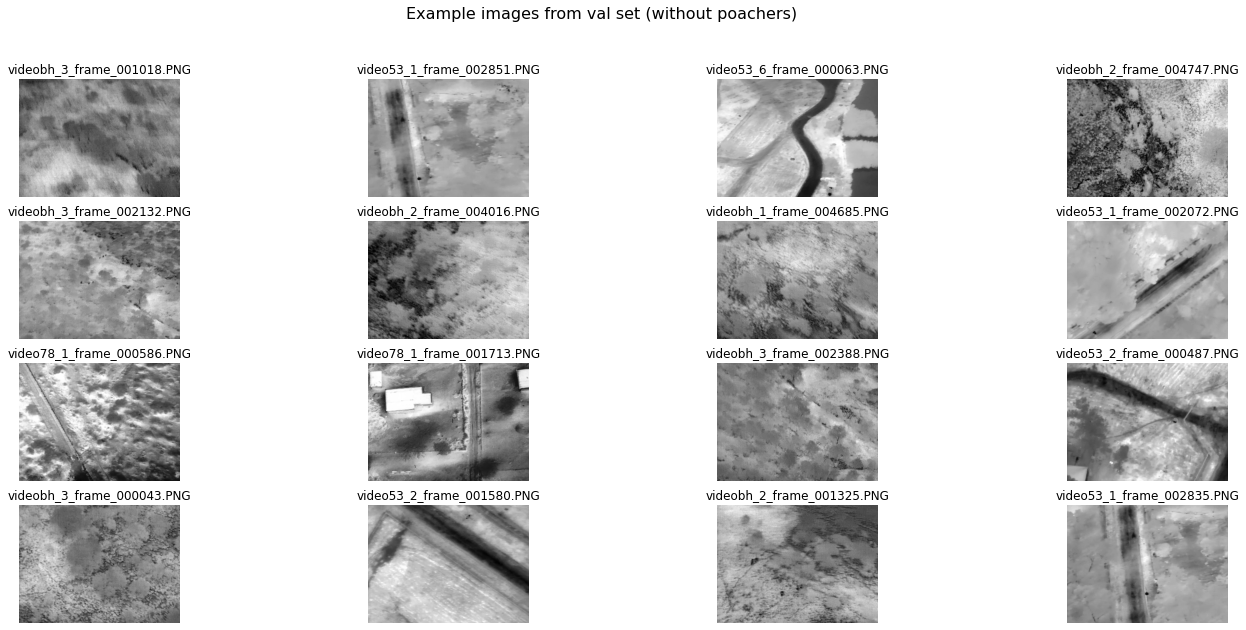

In [ ]:
# visualizing sample images from val set 
dst_val_filenames = os.listdir(dst_val_folder)
dst_val_filepaths = [os.path.join(dst_val_folder, name) for name in dst_val_filenames ]
num_images_to_plot  = 16 
fig, axes = plt.subplots(4,4 , figsize=(24,10))
axes = axes.ravel()
for i in range(num_images_to_plot) :
  ax = axes[i]
  image_path = random.choice(dst_val_filepaths)
  image_name = image_path.split(os.path.sep)[-1]
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  ax.imshow(image, cmap='gray')
  ax.set_title(image_name)
  ax.axis('off')
fig.suptitle("Example images from val set (without poachers)", fontsize=16)
plt.show()


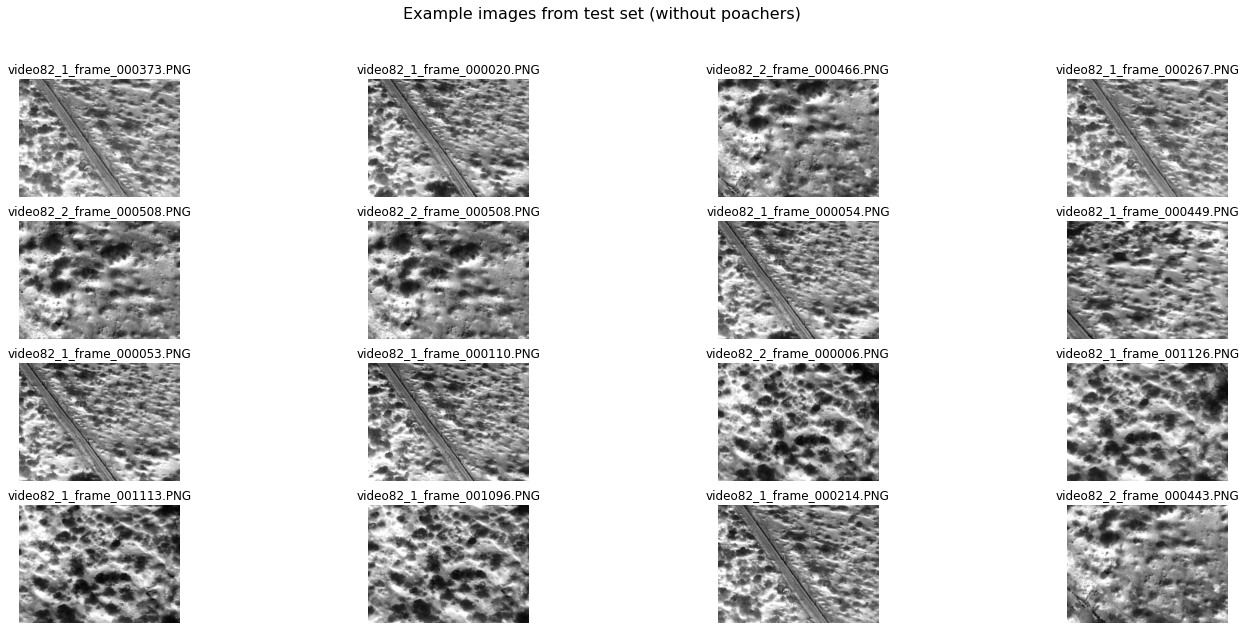

In [ ]:
# visualizing sample images from test set 
dst_test_filenames = os.listdir(dst_test_folder)
dst_test_filepaths = [os.path.join(dst_test_folder, name) for name in dst_test_filenames ]
num_images_to_plot  = 16 
fig, axes = plt.subplots(4,4 , figsize=(24,10))
axes = axes.ravel()
for i in range(num_images_to_plot) :
  ax = axes[i]
  image_path = random.choice(dst_test_filepaths)
  image_name = image_path.split(os.path.sep)[-1]
  image = cv2.imread(image_path, cv2.IMREAD_GRAYSCALE)
  ax.imshow(image, cmap='gray')
  ax.set_title(image_name)
  ax.axis('off')
fig.suptitle("Example images from test set (without poachers)", fontsize=16)
plt.show()

In [ ]:
# zipping images_without_poachers folder 
!zip -r images_without_poachers.zip images_without_poachers


Streaming output truncated to the last 5000 lines.
  adding: images_without_poachers/train/video53_1_frame_002707.PNG (deflated 1%)
  adding: images_without_poachers/train/videobh_2_frame_001468.PNG (deflated 0%)
  adding: images_without_poachers/train/videobh_2_frame_003405.PNG (deflated 0%)
  adding: images_without_poachers/train/videobh_2_frame_002361.PNG (deflated 0%)
  adding: images_without_poachers/train/videobh_1_frame_004450.PNG (deflated 0%)
  adding: images_without_poachers/train/videobh_3_frame_004607.PNG (deflated 0%)
  adding: images_without_poachers/train/video53_1_frame_000693.PNG (deflated 1%)
  adding: images_without_poachers/train/video53_2_frame_001978.PNG (deflated 0%)
  adding: images_without_poachers/train/videobh_2_frame_001625.PNG (deflated 0%)
  adding: images_without_poachers/train/video53_1_frame_000294.PNG (deflated 1%)
  adding: images_without_poachers/train/videobh_1_frame_004146.PNG (deflated 0%)
  adding: images_without_poachers/train/videobh_2_frame_00

In [ ]:
# copying zipped file to shared drive 
!cp images_without_poachers.zip '/content/drive/MyDrive/Local_FruitPunchAI_Wildlife2_Challenege/AI for Wildlife 2 Share/Sub-Groups/sub-models/dataset_images_without_poachers/'
